# QOSF Mentorship Program - Task 1

Design a quantum circuit that considers as input the following vector of integers numbers: 

[1,5,7,10]

returns a quantum state which is a superposition of indices of the target solution, obtaining in the output the indices of the inputs where two adjacent bits will always have different values. In this case the output should be: 

1/sqrt(2) * (|01> + |11>) , as the correct indices are 1 and 3.


In [2]:
# Program Task 1
# Created by: Andres Diaz
# Date: 9/29/2021

# Load packages and standard Qiskit libraries
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

from qiskit.visualization import circuit_drawer

In [3]:
# Problem input and creation of dictionary
#     dictionary key   = input number in binary (four bits/qubits)
#     dictionary value = indices in binary (two bits/qubits)
input_list = [1,5,7,10]
input_dict = {}
for num in range(len(input_list)):
    element_bin = format(input_list[num], '#06b')
    integer_bin = format(num,'#04b')
    input_dict[element_bin[-4:]] = integer_bin[-2:]
print(input_dict)

{'0001': '00', '0101': '01', '0111': '10', '1010': '11'}


In [4]:
# These definitions are not necessary (or used), but will be useful in we desire to generalize the program
# to accept random values of size 2^n with m bits in length
n = 2   # n = number of addressing qbits
m = 4   # m = number of bits in length for each memory element

In [5]:
# Configure backend
shots = 1024;
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=shots)

# Condition of two adjacents bits having different value is achieved 
# by AND operation between XOR of adjacent bits in binary representation 
expression = '(w ^ x) & (x ^ y) & (y ^ z)'

# Create new oracle
oracle = PhaseOracle(expression)
problem = AmplificationProblem(oracle)
oracle.draw()

q_0: ─■──■─────■─
      │  │     │ 
q_1: ─■──┼──■──■─
      │  │  │  │ 
q_2: ─┼──■──o──o─
      │  │  │    
q_3: ─o──o──■────

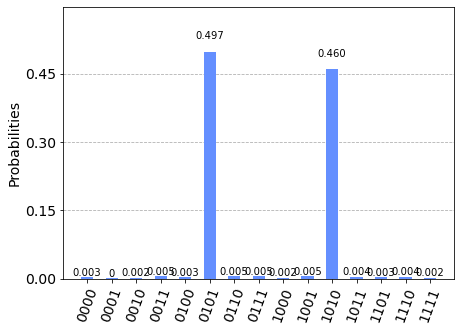

In [14]:
# Solve using Grover's algorithm
# Since we know the number of solutions is always going to be 2, the optimal number of iterations can be calculated 
# or obtained using the method optimal_num_iterations. In this case it is equal to 2
grover = Grover(iterations = 2, quantum_instance=quantum_instance)
result = grover.amplify(problem)
plot_histogram(result.circuit_results)

In [20]:
print(result.circuit_results[0])

{'0101': 509, '1001': 5, '1010': 471, '0100': 3, '1111': 2, '0010': 2, '0111': 5, '0000': 3, '0110': 5, '0011': 5, '1000': 2, '1110': 4, '1011': 4, '1101': 3, '0001': 1}


In [21]:
# Determine probabilities corresponding to input elements
# and assign to output dictionary with keys = indices in binary
output_dict = {}
for input_key in input_dict.keys():
    print(input_key,input_dict[input_key],result.circuit_results[0][input_key]/shots)
    output_dict[input_dict[input_key]] = result.circuit_results[0][input_key]/shots

0001 00 0.0009765625
0101 01 0.4970703125
0111 10 0.0048828125
1010 11 0.4599609375


In [22]:
print(output_dict)

{'00': 0.0009765625, '01': 0.4970703125, '10': 0.0048828125, '11': 0.4599609375}


In [23]:
# It is given that the input contains at least two numbers with alternating bitstrings
# Hence, we look for the two highest probabilities. Only states are stored in output_list
max1 = max(output_dict, key = output_dict.get)
del output_dict[max1]
max2 = max(output_dict, key = output_dict.get)
output_list = [max1,max2]
print(output_list)

['01', '11']


In [24]:
# The output will be a quantum circuit which is the superposition of these two states
# Prepare list of complex amplitudes of [00,01,10,11] states
states = ['00','01','10','11']
amplitudes = [0,0,0,0]
for num in range(len(states)):
    if states[num] in output_list:
        amplitudes[num] = 1/np.sqrt(2)
    else:
        amplitudes[num] = 0    
    print(states[num], amplitudes[num])
    
# Declare and initialize output quantum circuit qc_out with the desired superposition of states
qc_out = QuantumCircuit(2)
qc_out.initialize(amplitudes, [0,1])
qc_out.draw()

00 0
01 0.7071067811865475
10 0
11 0.7071067811865475


┌──────────────────────────────────┐
q_0: ┤0                                 ├
     │  Initialize(0,0.70711,0,0.70711) │
q_1: ┤1                                 ├
     └──────────────────────────────────┘

# Notes

If the optimal number of iterations for Grover's algorithm is not used, the method  still work but the probabilities of the max states will be slightly lower (e.g. around 0.35).

# Improvements and variations of this program
## 1. Generalize for vectors of random values of size $2^{n}$

The program can be easily adapted to accept random values of size $2^{n}$ with m bits in length, for fixed values of n and m. An example is given in the file Task1_variation1, where n is kept at 2, but I consider cells of 5 bits in length. With a bit more time (and not too much extra effort), this program can be generalized to have n and m as parameters that can be adjusted at will.

## 2. Prepare input state as superposition of only the states defined by given vector
As can be seen in the solution provided, the application of Grover's algorithm uses as input the equal superposition of all possible $2^{m}$ states. A further optimization to consider is to prepare the input state as the equal superposition of just the states defined by the input vector. In a real case, this should considerably improve the stability and reduce the noise in the system, since less states are considered. For the given input vector, this approach would consist of the state:
       1/2(|0001> + |0101> + |0111> + |1010>)
This approach is implemented in file Task1_variation2

## 3. Define the oracle so that it only operates on states defined by the input vector
Another approach is to define the oracle so that it only operates on states |0001>, |0101>, |0111>, and |1010>, returning zero when operating on all other states. As with the previous approach, this should also results in less noise and a more stable program. This approach was not implemented.

## 4. Use bucket-brigade approach
The final approach is to use the bucket-brigrade approach (as explained in https://github.com/qsharp-community/qram/blob/master/docs/primer.pdf). Below I implemented the circuit that performs the query |i> -> $(-1)^{mi}$|i> when n=2 given the input vector [1,5,7,10]. 

In [28]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
qreg_q = QuantumRegister(26, 'q')
circuit = QuantumCircuit(qreg_q) 
# Address register  : bits 0-1
# Auxiliary register: bits 2-5
# Memory register   : bits 6-9 for |0001>, 10-13 for |0101>, 14-17 for |0111>, and 18-21 for |1010> (all initialized)
# Output register   : bits 22-25 (initialized to |1>)
circuit.x(qreg_q[2])
circuit.x(qreg_q[6])
circuit.x(qreg_q[10])
circuit.x(qreg_q[12])
circuit.x(qreg_q[14])
circuit.x(qreg_q[15])
circuit.x(qreg_q[16])
circuit.x(qreg_q[19])
circuit.x(qreg_q[21])
circuit.x(qreg_q[22])
circuit.x(qreg_q[23])
circuit.x(qreg_q[24])
circuit.x(qreg_q[25])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.cx(qreg_q[3], qreg_q[2])
circuit.ccx(qreg_q[0], qreg_q[2], qreg_q[4])
circuit.ccx(qreg_q[1], qreg_q[3], qreg_q[5])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.cx(qreg_q[5], qreg_q[3])
circuit.ccx(qreg_q[2], qreg_q[6], qreg_q[22])
circuit.ccx(qreg_q[2], qreg_q[7], qreg_q[23])
circuit.ccx(qreg_q[2], qreg_q[8], qreg_q[24])
circuit.ccx(qreg_q[2], qreg_q[9], qreg_q[25])
circuit.ccx(qreg_q[3], qreg_q[10], qreg_q[22])
circuit.ccx(qreg_q[3], qreg_q[11], qreg_q[23])
circuit.ccx(qreg_q[3], qreg_q[12], qreg_q[24])
circuit.ccx(qreg_q[3], qreg_q[13], qreg_q[25])
circuit.ccx(qreg_q[4], qreg_q[14], qreg_q[22])
circuit.ccx(qreg_q[4], qreg_q[15], qreg_q[23])
circuit.ccx(qreg_q[4], qreg_q[16], qreg_q[24])
circuit.ccx(qreg_q[4], qreg_q[17], qreg_q[25])
circuit.ccx(qreg_q[5], qreg_q[18], qreg_q[22])
circuit.ccx(qreg_q[5], qreg_q[19], qreg_q[23])
circuit.ccx(qreg_q[5], qreg_q[20], qreg_q[24])
circuit.ccx(qreg_q[5], qreg_q[21], qreg_q[25])
circuit.draw()

»
 q_0: ─────────────────■────────────────────────────────────────────────────»
                       │                                                    »
 q_1: ───────■─────────┼────■───────────────────────────────────────────────»
      ┌───┐  │  ┌───┐  │    │  ┌───┐                                        »
 q_2: ┤ X ├──┼──┤ X ├──■────┼──┤ X ├───────■────■─────────■──────────────■──»
      └───┘┌─┴─┐└─┬─┘  │    │  └─┬─┘┌───┐  │    │         │              │  »
 q_3: ─────┤ X ├──■────┼────■────┼──┤ X ├──┼────┼────■────┼────■─────────┼──»
           └───┘     ┌─┴─┐  │    │  └─┬─┘  │    │    │    │    │         │  »
 q_4: ───────────────┤ X ├──┼────■────┼────┼────┼────┼────┼────┼────■────┼──»
                     └───┘┌─┴─┐       │    │    │    │    │    │    │    │  »
 q_5: ────────────────────┤ X ├───────■────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐               └───┘            │    │    │    │    │    │    │  »
 q_6: ┤ X ├────────────────────────────────■────┼────┼────┼────┼────┼────┼──»
      └───┘                                │    │    │    │    │    │    │  »
 q_7: ─────────────────────────────────────┼────■────┼────┼────┼────┼────┼──»
                                           │    │    │    │    │    │    │  »
 q_8: ─────────────────────────────────────┼────┼────┼────■────┼────┼────┼──»
                                           │    │    │    │    │    │    │  »
 q_9: ─────────────────────────────────────┼────┼────┼────┼────┼────┼────■──»
      ┌───┐                                │    │    │    │    │    │    │  »
q_10: ┤ X ├────────────────────────────────┼────┼────■────┼────┼────┼────┼──»
      └───┘                                │    │    │    │    │    │    │  »
q_11: ─────────────────────────────────────┼────┼────┼────┼────■────┼────┼──»
      ┌───┐                                │    │    │    │    │    │    │  »
q_12: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      └───┘                                │    │    │    │    │    │    │  »
q_13: ─────────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐                                │    │    │    │    │    │    │  »
q_14: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────■────┼──»
      ├───┤                                │    │    │    │    │    │    │  »
q_15: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      ├───┤                                │    │    │    │    │    │    │  »
q_16: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      └───┘                                │    │    │    │    │    │    │  »
q_17: ─────────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
                                           │    │    │    │    │    │    │  »
q_18: ─────────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐                                │    │    │    │    │    │    │  »
q_19: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      └───┘                                │    │    │    │    │    │    │  »
q_20: ─────────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      ┌───┐                                │    │    │    │    │    │    │  »
q_21: ┤ X ├────────────────────────────────┼────┼────┼────┼────┼────┼────┼──»
      ├───┤                              ┌─┴─┐  │  ┌─┴─┐  │    │  ┌─┴─┐  │  »
q_22: ┤ X ├──────────────────────────────┤ X ├──┼──┤ X ├──┼────┼──┤ X ├──┼──»
      ├───┤                              └───┘┌─┴─┐└───┘  │  ┌─┴─┐└───┘  │  »
q_23: ┤ X ├───────────────────────────────────┤ X ├───────┼──┤ X ├───────┼──»
      ├───┤                                   └───┘     ┌─┴─┐└───┘       │  »
q_24: ┤ X ├─────────────────────────────────────────────┤ X ├────────────┼──»
      ├───┤                                             └───┘          ┌─┴─┐»
q_25: ┤ X ├────────────────────────────────────────────────────────────┤ X ├»
      └───┘         